In [1]:
import matplotlib.pyplot as plt
import numpy as np

# pytorch library
import torch 
import torch.nn.functional as F # the sub-library containing different functions for manipulating with tensors
from transformers import BertModel, BertTokenizer

In [3]:
# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
bert_version = 'bert-large-cased'
tokenizer = BertTokenizer.from_pretrained(bert_version)
model = BertModel.from_pretrained(bert_version)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
# model is configured for production.
model = model.eval()
# model to device(GPU)
model = model.to(device)

In [7]:
texts  = [
    'Obama speaks to the media in Illinois',
    'The president greets the press in Chicago',
    'Oranges are my favorite fruit',
]

In [8]:
encodings = tokenizer(
    texts, # the texts to be tokenized
    padding = True, # pad the texts to the maximum length
    return_tensors='pt' # return tensors
)

In [9]:
encodings = encodings.to(device)

In [24]:
print('Encoding keys:', *encodings.keys())
# input_ids:
# 101 represents the class token [CLS]
# 102 represents [SEP]
# 0 represents [PAD]
print(encodings['input_ids'])
# Attention_mask: represents which ids to use when generating the tokens 
# (e.g. ignores the [PAD] tokens
print(encodings['attention_mask'])
# token_type_ids: represents which tokens correspond to the first and second sentence 
# used for next sentence prediction
print(encodings['token_type_ids'])

Encoding keys: input_ids token_type_ids attention_mask
tensor([[  101,  7661,  8917,  1106,  1103,  2394,  1107,  3461,   102,     0],
        [  101,  1109,  2084, 18884,  1116,  1103,  3181,  1107,  2290,   102],
        [  101,  6309,  1116,  1132,  1139,  5095,  5735,   102,     0,     0]],
       device='cuda:0')
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0]], device='cuda:0')
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')


In [13]:
# convert the ids into tokens and output their representaitons
for tokens in encodings['input_ids']:
    print(tokenizer.convert_ids_to_tokens(tokens))

['[CLS]', 'Obama', 'speaks', 'to', 'the', 'media', 'in', 'Illinois', '[SEP]', '[PAD]']
['[CLS]', 'The', 'president', 'greet', '##s', 'the', 'press', 'in', 'Chicago', '[SEP]']
['[CLS]', 'Orange', '##s', 'are', 'my', 'favorite', 'fruit', '[SEP]', '[PAD]', '[PAD]']


In [28]:
# disable gradient calculations
with torch.no_grad():
    # get the model embeddings
    embeds = model(**encodings)

In [29]:
# embeds[0] contains the embeddings of the sentence tokens
# embeds[1] contains the embeddings of the [CLS] token being sent further to train the next sentence prediction.
print(embeds[1])
embeds = embeds[0]

tensor([[ 0.9926, -0.8740, -0.9317,  ...,  0.9540, -0.9300,  0.6516],
        [ 0.9782,  0.8172,  0.9791,  ..., -0.9856, -0.0752,  0.9397],
        [ 0.9805,  0.9990,  0.9995,  ..., -1.0000,  0.1070,  0.9760]],
       device='cuda:0')


In [30]:
# to get the size of the tensor use .shape (similar as with numpy)
embeds.shape

torch.Size([3, 10, 1024])

In [31]:
def visualize(distances, figsize=(10, 5), titles=None):
    # get the number of columns
    ncols = len(distances)
    # create the subplot placeholders
    fig, ax = plt.subplots(ncols=ncols, figsize=figsize)
    
    for i in range(ncols):
        
        # get the axis in which we will draw the matrix
        axes = ax[i] if ncols > 1 else ax
        
        # get the i-th distance
        distance = distances[i]
        
        # create the heatmap
        axes.imshow(distance)
        
        # show the ticks
        axes.set_xticks(np.arange(distance.shape[0]))
        axes.set_yticks(np.arange(distance.shape[1]))
        
        # set the tick labels
        axes.set_xticklabels(np.arange(distance.shape[0]))
        axes.set_yticklabels(np.arange(distance.shape[1]))
        
        # set the values in the heatmap
        for j in range(distance.shape[0]):
            for k in range(distance.shape[1]):
                text = axes.text(k, j, str(round(distance[j, k], 3)),
                               ha="center", va="center", color="w")
        
        # set the title of the subplot
        title = titles[i] if titles and len(titles) > i else "Text Distance"
        axes.set_title(title, fontsize="x-large")
        
    fig.tight_layout()
    plt.show()

In [35]:
# Use the [CLS] Embeddings
# 0 : [CLS] for each sentence
CLSs = embeds[:, 0, :]
print(CLSs)

tensor([[ 0.0674, -0.6799, -0.0995,  ..., -0.7554, -0.1278, -0.0802],
        [-0.0607, -0.6513,  0.0976,  ..., -0.5838, -0.2506, -0.0793],
        [-0.5826, -0.4716,  0.3686,  ..., -0.3705, -0.7758, -0.1986]],
       device='cuda:0')


In [37]:
# normalize the CLS token embeddings
normalized = F.normalize(CLSs, p=2, dim=1)
# calculate the cosine similarity
cls_dist = normalized.matmul(normalized.T)
cls_dist = cls_dist.new_ones(cls_dist.shape) - cls_dist
cls_dist = cls_dist.cpu().numpy()

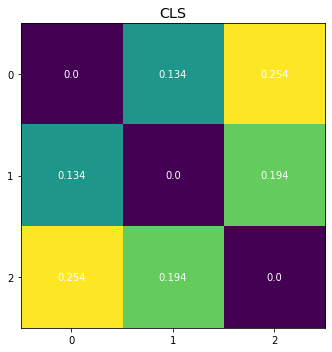

In [38]:
visualize([cls_dist], titles=["CLS"])

In [42]:
MEANS = embeds.mean(dim = 1)
# normalize the MEANS token embeddings
normalized = F.normalize(MEANS, p = 2, dim=1)
# calculate the cosine similarity
mean_dist = normalized.matmul(normalized.T)
mean_dist = mean_dist.new_ones(mean_dist.shape) - mean_dist
mean_dist = mean_dist.cpu().numpy()

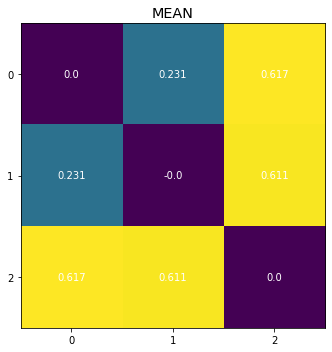

In [43]:
visualize([mean_dist], titles=["MEAN"])

In [46]:
#Compute the max-over-time of the Output Vectors
MAXS, _ = embeds.max(dim=1)
# normalize the MEANS token embeddings
normalized = F.normalize(MAXS, p=2, dim=1)
# calculate the cosine similarity
max_dist = normalized.matmul(normalized.T)
max_dist = max_dist.new_ones(max_dist.shape) - max_dist
max_dist = max_dist.cpu().numpy()

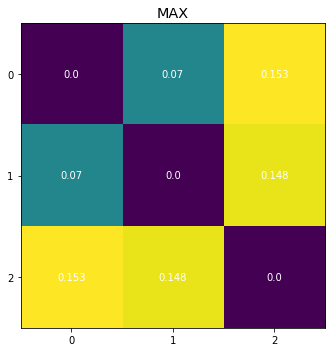

In [47]:
visualize([max_dist], titles=["MAX"])

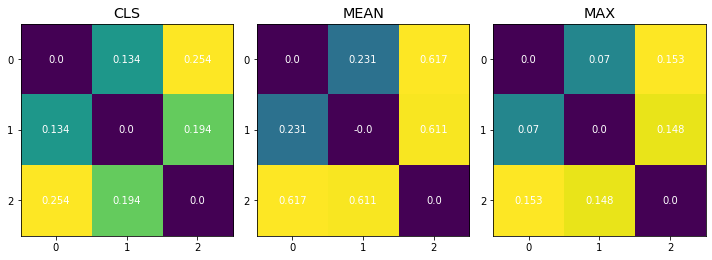

In [48]:
dist = [cls_dist, mean_dist, max_dist]
titles = ["CLS", "MEAN", "MAX"]
visualize(dist, titles=titles)